In [1]:
from keras.layers import Dense, Input, Activation, ELU, Flatten, Conv2D
from keras.models import Sequential
import keras
import numpy as np

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from keras import backend as K
import tensorflow as tf
with K.tf.device('/gpu:0'):
    config = tf.ConfigProto(intra_op_parallelism_threads=4,\
           inter_op_parallelism_threads=4, allow_soft_placement=True,\
           device_count = {'CPU' : 1, 'GPU' : 1})
    session = tf.Session(config=config)
    K.set_session(session)

# Part

In [3]:
from keras.utils import to_categorical
dataset = keras.datasets.mnist.load_data()

X_train = dataset[0][0]
y_train = dataset[0][1]
X_test = dataset[1][0]
y_test = dataset[1][1]

X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

digits_train = {}
digits_test = {}

for i in range(10):
    digits_train[i] = np.where(y_train==i)[0]
    digits_test[i] = np.where(y_test==i)[0]
    
X_train0 = X_train[np.concatenate([digits_train[i] for i in range(5)])]
y_train0 = to_categorical(y_train[np.concatenate([digits_train[i] for i in range(5)])], num_classes=5)

X_test0 = X_test[np.concatenate([digits_test[i] for i in range(5)])]
y_test0 = to_categorical(y_test[np.concatenate([digits_test[i] for i in range(5)])], num_classes=5)

X_train5 = X_train[np.concatenate([digits_train[i] for i in range(5, 10)])]
y_train5 = to_categorical(y_train[np.concatenate([digits_train[i] for i in range(5, 10)])] - 5, num_classes=5)

X_test5 = X_test[np.concatenate([digits_test[i] for i in range(5, 10)])]
y_test5 = to_categorical(y_test[np.concatenate([digits_test[i] for i in range(5, 10)])] - 5, num_classes=5)

In [4]:
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout

def get_model(he_init=False, dropout=False, batch_norm=False):
    if he_init:
        params = {'activation':keras.activations.elu, 'kernel_initializer':keras.initializers.he_uniform(seed=11)}
    else:
        params = {'activation':keras.activations.elu}
            
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(100,**params))
    if batch_norm: model.add(BatchNormalization())
    if dropout: model.add(Dropout(0.5))
    
    model.add(Dense(100,**params))
    if batch_norm: model.add(BatchNormalization())
    if dropout: model.add(Dropout(0.5))
    
    model.add(Dense(100,**params))
    
    if batch_norm: model.add(BatchNormalization())
    if dropout: model.add(Dropout(0.5))
        
    model.add(Dense(100,**params))
    if batch_norm: model.add(BatchNormalization())
    if dropout: model.add(Dropout(0.5))
    
    model.add(Dense(100,**params))
    if batch_norm: model.add(BatchNormalization())
    if dropout: model.add(Dropout(0.5))
        
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [5]:
BATCH_SIZE = 32
N_EPOCHS = 10
optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model = get_model(batch_norm=1)

model.compile(optimizer=optimizer, 
              loss=loss,
              metrics=metrics
             )

logs = model.fit(X_train0, y_train0,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          verbose=1, 
          validation_data=(X_test0, y_test0)
         )

Train on 30596 samples, validate on 5139 samples
Epoch 1/10
30596/30596 [==============================] - 10s 324us/step - loss: 0.1608 - acc: 0.9539 - val_loss: 0.0520 - val_acc: 0.9819
Epoch 2/10
30596/30596 [==============================] - 9s 279us/step - loss: 0.0916 - acc: 0.9745 - val_loss: 0.0407 - val_acc: 0.9883
Epoch 3/10
30596/30596 [==============================] - 8s 272us/step - loss: 0.0689 - acc: 0.9801 - val_loss: 0.0469 - val_acc: 0.9885
Epoch 4/10
30596/30596 [==============================] - 8s 273us/step - loss: 0.0608 - acc: 0.9825 - val_loss: 0.0358 - val_acc: 0.9897
Epoch 5/10
30596/30596 [==============================] - 10s 336us/step - loss: 0.0482 - acc: 0.9865 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 6/10
30596/30596 [==============================] - 9s 286us/step - loss: 0.0422 - acc: 0.9882 - val_loss: 0.0286 - val_acc: 0.9909
Epoch 7/10
30596/30596 [==============================] - 8s 271us/step - loss: 0.0401 - acc: 0.9883 - val_loss: 0.0323 -

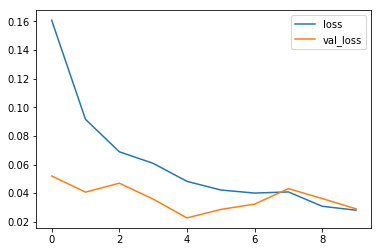

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for param in ['loss']:
    for prefix in ['', 'val_']:
        key= prefix+param
        plt.plot(logs.history[key],label=key)
plt.legend()
plt.show()

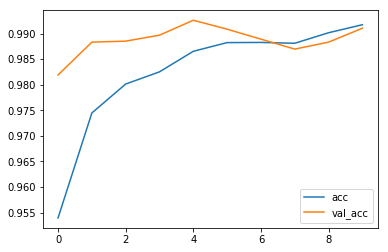

In [7]:
for param in ['acc']:
    for prefix in ['', 'val_']:
        key= prefix+param
        plt.plot(logs.history[key],label=key)
plt.legend()
plt.show()

# Part

Transfer learning

In [8]:
from keras.models import Model
o = (Activation('softmax'))(model.layers[-2].output)
model2 = Model(input=model.input, output=[o])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1_input (InputLay (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("se..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#freezing layers
for layer in model2.layers:
    if layer.name != 'dense_6':
        layer.trainable = False

In [10]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1_input (InputLay (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [11]:
BATCH_SIZE = 32
N_EPOCHS = 10
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model2.compile(optimizer=optimizer, 
              loss=loss,
              metrics=metrics
             )

logs = model2.fit(X_train5, y_train5,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          verbose=1, 
          validation_data=(X_test5, y_test5)
         )

Train on 29404 samples, validate on 4861 samples
Epoch 1/10
29404/29404 [==============================] - 3s 114us/step - loss: 2.4777 - acc: 0.4933 - val_loss: 1.1906 - val_acc: 0.5161
Epoch 2/10
29404/29404 [==============================] - 3s 102us/step - loss: 1.1224 - acc: 0.5716 - val_loss: 1.0946 - val_acc: 0.5571
Epoch 3/10
29404/29404 [==============================] - 3s 101us/step - loss: 1.0471 - acc: 0.5896 - val_loss: 1.1175 - val_acc: 0.5441
Epoch 4/10
29404/29404 [==============================] - 3s 101us/step - loss: 1.0316 - acc: 0.5963 - val_loss: 1.1078 - val_acc: 0.5526
Epoch 5/10
29404/29404 [==============================] - 3s 100us/step - loss: 1.0203 - acc: 0.5985 - val_loss: 1.1173 - val_acc: 0.5435
Epoch 6/10
29404/29404 [==============================] - 3s 103us/step - loss: 1.0166 - acc: 0.5994 - val_loss: 1.1135 - val_acc: 0.5495
Epoch 7/10
29404/29404 [==============================] - 3s 100us/step - loss: 1.0066 - acc: 0.6016 - val_loss: 1.1114 - v

Unfreeze more layers

In [12]:
#unfreezing layers
for layer in model2.layers:
    if layer.name in ['dense_5', 'dense_4']:
        layer.trainable = True

In [13]:
BATCH_SIZE = 32
N_EPOCHS = 10
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model2.compile(optimizer=optimizer, 
              loss=loss,
              metrics=metrics
             )

logs = model2.fit(X_train5, y_train5,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          verbose=1, 
          validation_data=(X_test5, y_test5)
         )

Train on 29404 samples, validate on 4861 samples
Epoch 1/10
29404/29404 [==============================] - 5s 183us/step - loss: 0.9758 - acc: 0.6121 - val_loss: 1.1288 - val_acc: 0.5454
Epoch 2/10
29404/29404 [==============================] - 4s 148us/step - loss: 0.9416 - acc: 0.6312 - val_loss: 1.1515 - val_acc: 0.5380
Epoch 3/10
29404/29404 [==============================] - 4s 143us/step - loss: 0.9022 - acc: 0.6540 - val_loss: 1.1738 - val_acc: 0.5273
Epoch 4/10
29404/29404 [==============================] - 4s 148us/step - loss: 0.8591 - acc: 0.6742 - val_loss: 1.2130 - val_acc: 0.5102
Epoch 5/10
29404/29404 [==============================] - 4s 145us/step - loss: 0.8146 - acc: 0.7001 - val_loss: 1.2493 - val_acc: 0.4871
Epoch 6/10
29404/29404 [==============================] - 4s 149us/step - loss: 0.7587 - acc: 0.7250 - val_loss: 1.2845 - val_acc: 0.4485
Epoch 7/10
29404/29404 [==============================] - 4s 149us/step - loss: 0.7102 - acc: 0.7425 - val_loss: 1.2779 - v

And even more

In [14]:
#unfreezing layers
for layer in model2.layers:
    if layer.name in ['dense_3', 'dense_2']:
        layer.trainable = True

In [15]:
BATCH_SIZE = 32
N_EPOCHS = 10
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model2.compile(optimizer=optimizer, 
              loss=loss,
              metrics=metrics
             )

logs = model2.fit(X_train5, y_train5,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          verbose=1, 
          validation_data=(X_test5, y_test5)
         )

Train on 29404 samples, validate on 4861 samples
Epoch 1/10
29404/29404 [==============================] - 6s 208us/step - loss: 0.4843 - acc: 0.8321 - val_loss: 1.2175 - val_acc: 0.4666
Epoch 2/10
29404/29404 [==============================] - 5s 183us/step - loss: 0.3501 - acc: 0.8811 - val_loss: 1.1341 - val_acc: 0.4980
Epoch 3/10
29404/29404 [==============================] - 5s 183us/step - loss: 0.2831 - acc: 0.9036 - val_loss: 1.1150 - val_acc: 0.5180
Epoch 4/10
29404/29404 [==============================] - 5s 186us/step - loss: 0.2461 - acc: 0.9170 - val_loss: 1.0992 - val_acc: 0.5289
Epoch 5/10
29404/29404 [==============================] - 5s 185us/step - loss: 0.2235 - acc: 0.9251 - val_loss: 1.0561 - val_acc: 0.5600
Epoch 6/10
29404/29404 [==============================] - 5s 184us/step - loss: 0.2067 - acc: 0.9306 - val_loss: 1.0849 - val_acc: 0.5505
Epoch 7/10
29404/29404 [==============================] - 5s 186us/step - loss: 0.1927 - acc: 0.9353 - val_loss: 1.0810 - v